In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#%matplotlib inline

from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

In [2]:
file_path = '../data/store_sales_train.csv'
df = pd.read_csv(file_path, index_col = "Date", low_memory=False, parse_dates=['Date'])

In [3]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [5]:
#Choose Store 2 
df = df[df["Store"] == 2]
df = df.asfreq('D')
df.sort_values(by="Date", inplace=True)

### Define Functions

In [6]:
#KPSS Function
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

In [7]:
#ADF Function
def adf_test(data,threshold=0.05):
    # Perform ADF test
    result = adfuller(data,autolag="AIC")
    
    # Print test results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    
    if result[1] <= threshold:
        print("Conclusion:====>") 
        print("Reject the null hypothesis") 
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis") 
        print("Data is non-stationary")

In [8]:
#Autocorrelation Graphs
def autocorrelation_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

In [9]:
#Caclulate RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

In [10]:
#Split Data
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

In [11]:
train_data['year'] = train_data.index.year
train_data['month'] = train_data.index.month
train_data['day'] = train_data.index.day

# Convert the columns to integers
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)
train_data['day'] = train_data['day'].astype(int)

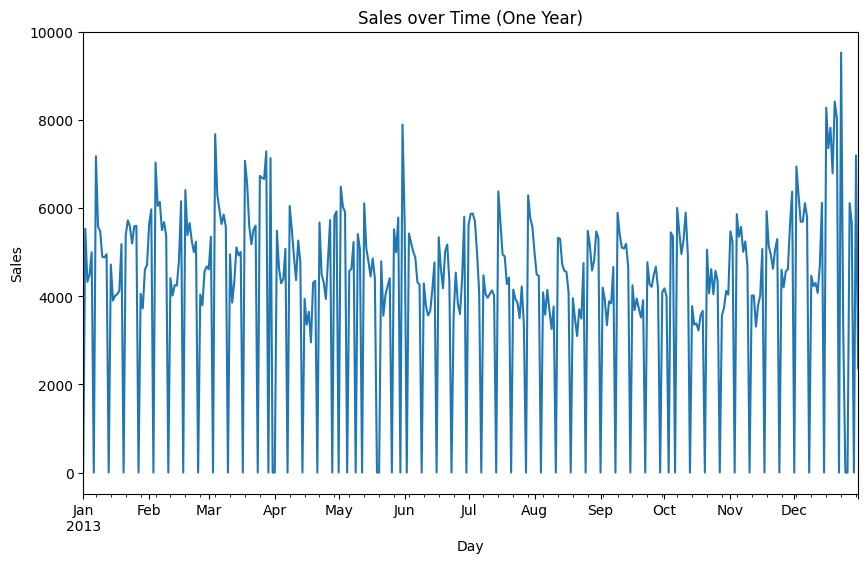

In [12]:
plt.figure(figsize=(10, 6))
train_data['Sales'][:365].plot()
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales over Time (One Year)')
plt.show()

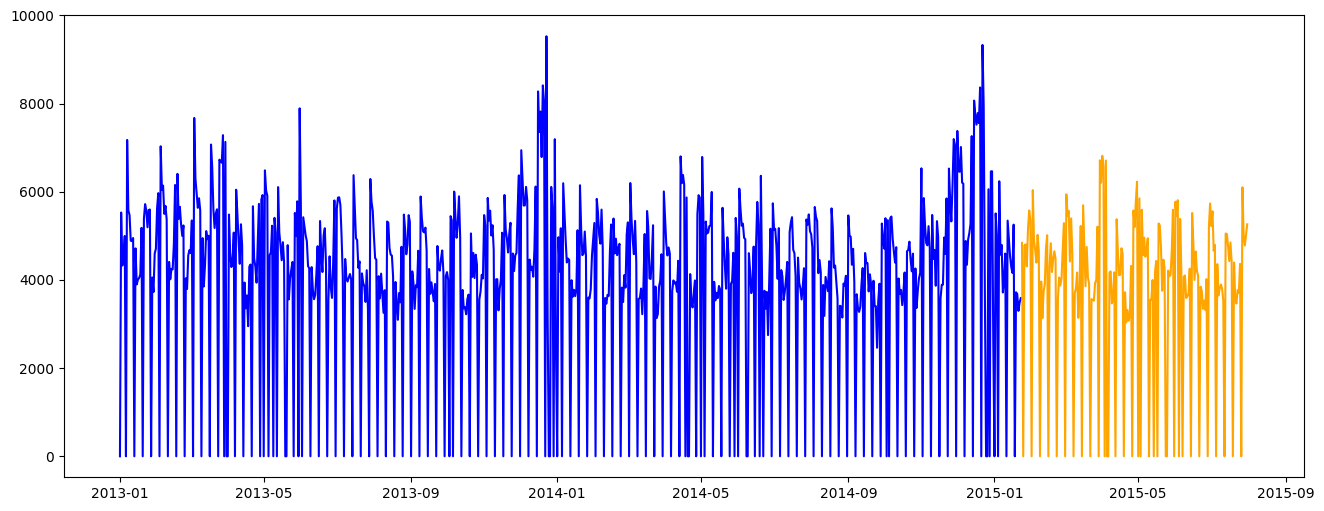

In [13]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes.plot(train_data["Sales"], label='Train',color='blue')
axes.plot(test_data["Sales"], label='Test',color='orange')
plt.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

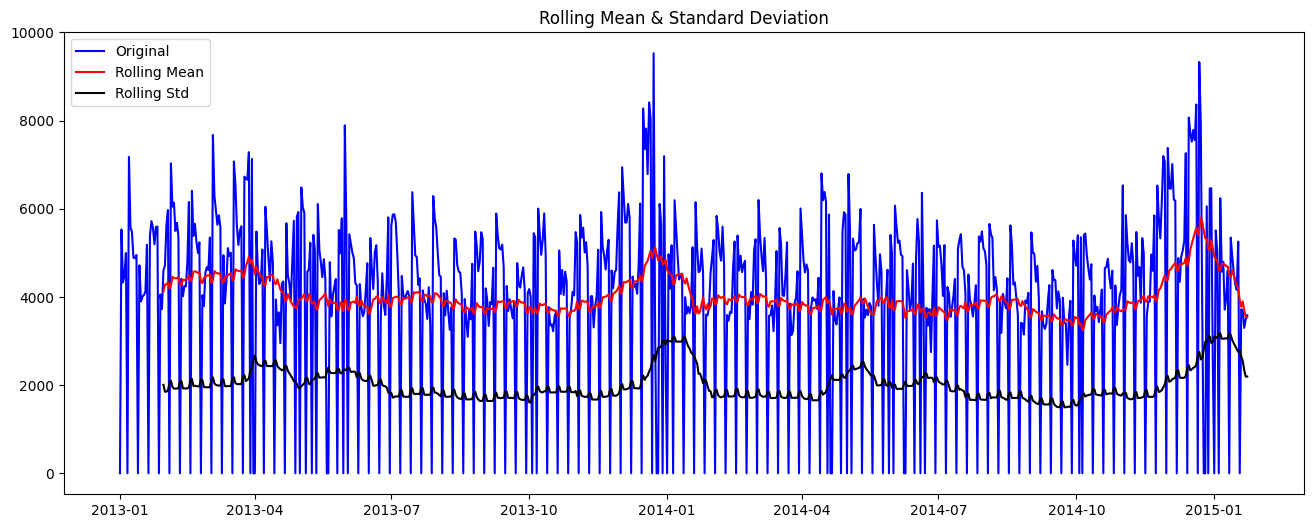

In [14]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)

#Determing rolling statistics
rolmean = train_data[["Sales"]].rolling( window=30).mean()
rolstd = train_data[["Sales"]].rolling(window=30).std()

#Plot rolling statistics:
orig = axes.plot(train_data[["Sales"]], color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

In [15]:
adf_test(train_data[["Sales"]])

ADF Statistic: -3.627864583541576
p-value: 0.005250125104946529
Critical Values:
	1%: -3.439314999916068
	5%: -2.8654965012008677
	10%: -2.5688768817372867
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [16]:
kpss_test(train_data[["Sales"]])

KPSS Statistic: 0.2099586392870777
p-value: 0.1
Lags Used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


C:\Users\FAH\AppData\Local\Temp\ipykernel_50604\2610321548.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data,regression="c")


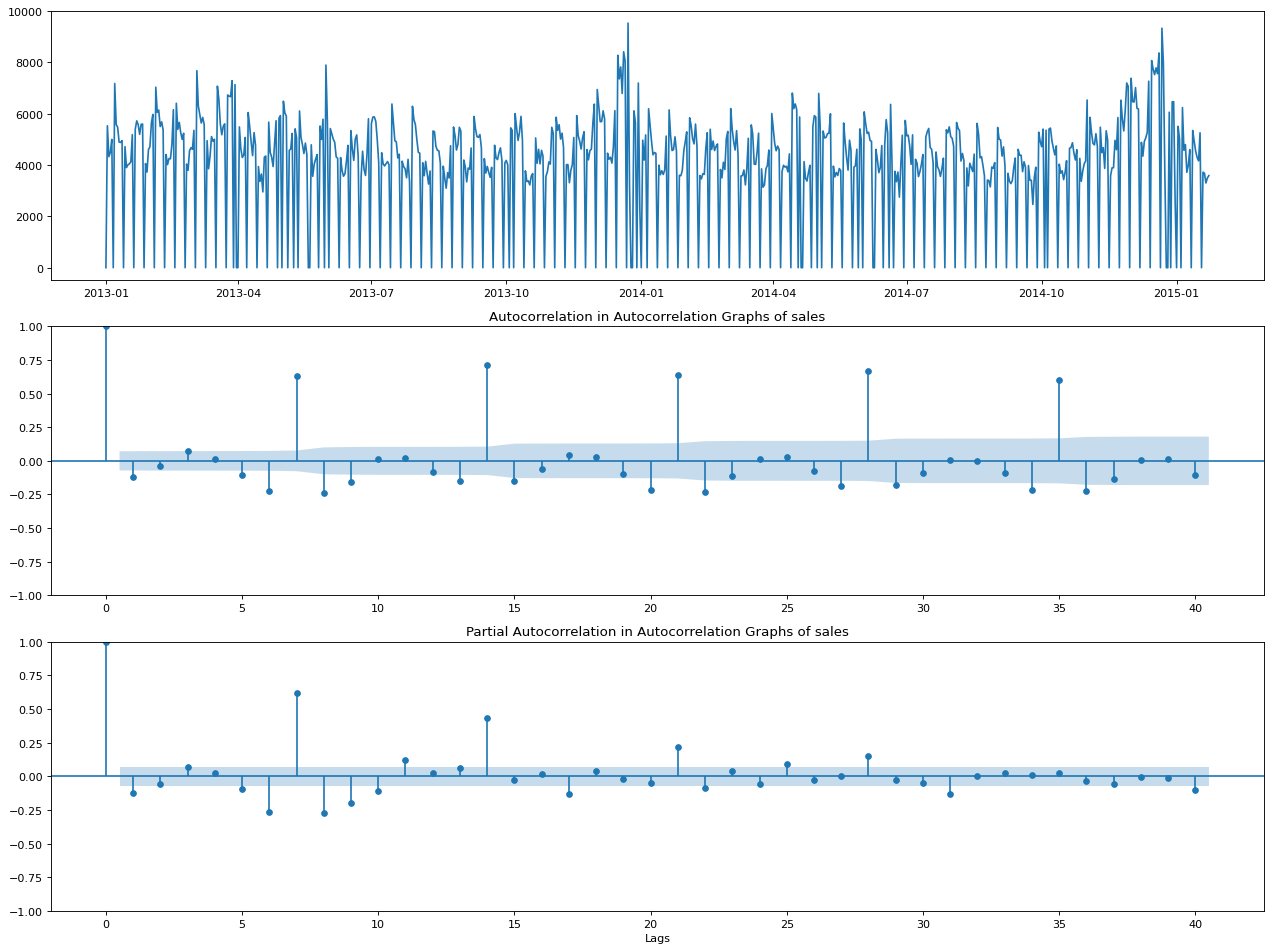

In [17]:
autocorrelation_graphs(train_data[["Sales"]], n_lags=40, title_text="Autocorrelation Graphs of sales")

In [18]:
ARIMA_model = ARIMA(train_data[["Sales"]], order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

In [19]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  753
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6799.437
Date:                Sat, 01 Feb 2025   AIC                          13604.874
Time:                        10:43:52   BIC                          13618.742
Sample:                    01-01-2013   HQIC                         13610.217
                         - 01-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1163      0.035     -3.347      0.001      -0.184      -0.048
ma.L1         -0.9999      0.079    -12.729      0.000      -1.154      -0.846
sigma2      4.142e+06   3.15e+05     13.162      0.000    3.53e+06    4.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                75.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.77
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1

#Predictions
arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)


In [21]:
arima_preds.head()


2015-01-24    4040.070883
2015-01-25    3987.241560
2015-01-26    3993.388040
2015-01-27    3992.672921
2015-01-28    3992.756123
Freq: D, Name: predicted_mean, dtype: float64

In [22]:
arima_preds[test_data["Open"] == 0] = "0"

C:\Users\FAH\AppData\Local\Temp\ipykernel_50604\133079428.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  arima_preds[test_data["Open"] == 0] = "0"


In [24]:
print(f'RMSPE for Arima on test:{rmspe(arima_preds,test_data[["Sales"]])}')

TypeError: unsupported operand type(s) for +: 'float' and 'str'

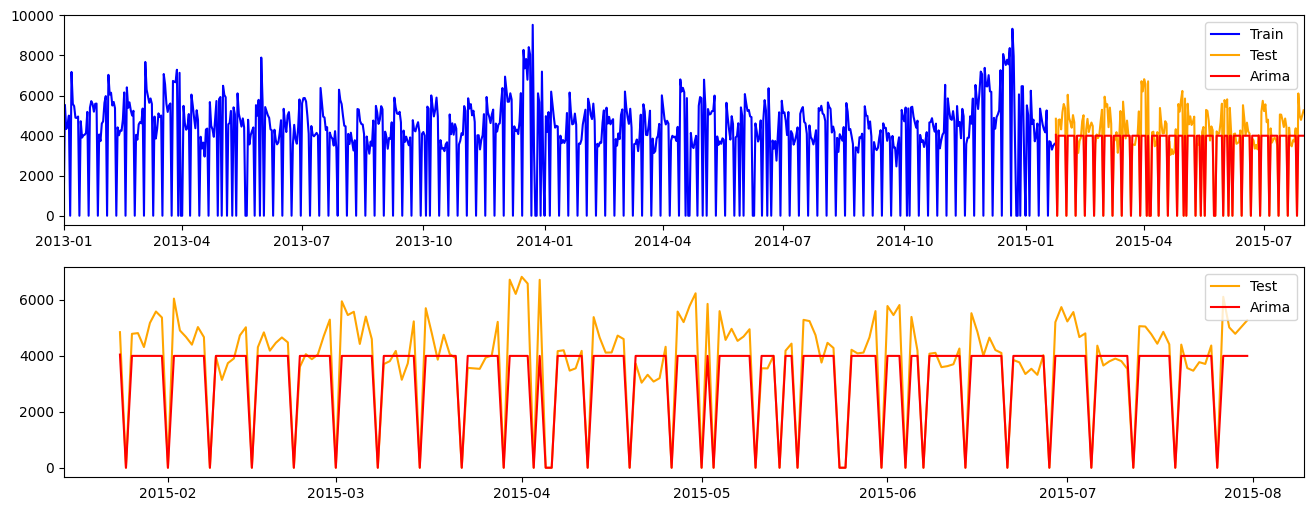

In [25]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)


axes[0].plot(train_data["Sales"], label='Train', color='blue')
axes[0].plot(test_data["Sales"], label='Test', color='orange')
axes[0].plot(arima_preds, label="Arima", color='red')
axes[0].legend(loc='best')
axes[0].set_xlim([df.index.min(), df.index.max()])

axes[1].plot(test_data["Sales"], label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()